# Install Detectron2 Dependencies

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 12 kB/s 
     |████████████████████████████████| 6.6 MB 52.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.5.0+cu101

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.3 MB 539 kB/s 
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 sha256=c437ef63afcfec5ffe9b72549caa19e4c52c6773d1328a566881946042e95683
  Stored in directory: /root/.cache/pip/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=e5f41140546cf63682c41fb54cce857c07f009b9ff367b6fb5526d3aed38de45
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [ ]:
!curl -L "https://universe.roboflow.com/ds/OcyGa35y9g?key=a6kSus0vFE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.9)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [ ]:
# We are importing our own Trainer Module here to use the COCO validation evaluation during training. 
# Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

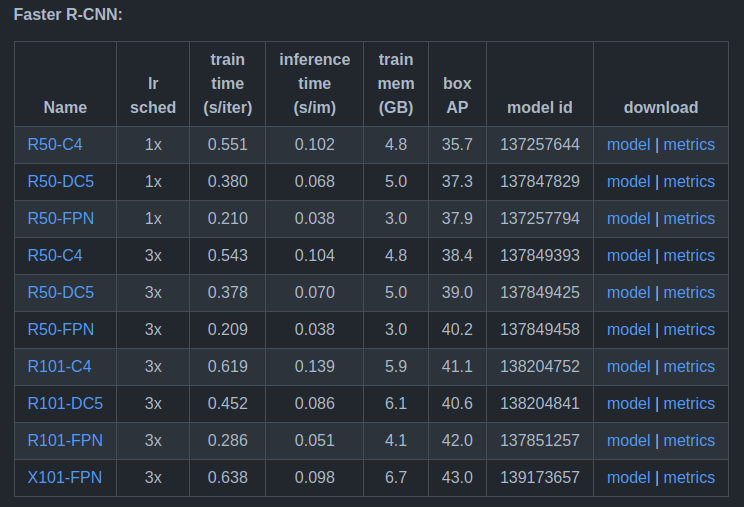

In [ ]:
# from .detectron2.tools.train_net import Trainer
# from detectron2.engine import DefaultTrainer

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # your number of classes (Number of foreground classes)

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/02 20:35:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:11, 35.6MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/02 20:35:40 d2.engine.train_loop]: Starting training from iteration 0
[01/02 20:36:38 d2.utils.events]:  eta: 1:36:36  iter: 19  total_loss: 1.282  loss_cls: 1.022  loss_box_reg: 0.000  loss_rpn_cls: 0.292  loss_rpn_loc: 0.013  time: 2.8846  data_time: 0.0431  lr: 0.000020  max_mem: 11274M
[01/02 20:37:44 d2.utils.events]:  eta: 1:40:23  iter: 39  total_loss: 0.822  loss_cls: 0.496  loss_box_reg: 0.000  loss_rpn_cls: 0.228  loss_rpn_loc: 0.012  time: 3.1000  data_time: 0.0174  lr: 0.000040  max_mem: 11274M
[01/02 20:38:49 d2.utils.events]:  eta: 1:41:58  iter: 59  total_loss: 0.490  loss_cls: 0.245  loss_box_reg: 0.000  loss_rpn_cls: 0.215  loss_rpn_loc: 0.014  time: 3.1427  data_time: 0.0179  lr: 0.000060  max_mem: 11274M
[01/02 20:39:54 d2.utils.events]:  eta: 1:44:21  iter: 79  total_loss: 0.291  loss_cls: 0.181  loss_box_reg: 0.000  loss_rpn_cls: 0.089  loss_rpn_loc: 0.014  time: 3.1726  data_time: 0.0241  lr: 0.000080  max_mem: 11274M
[01/02 20:40:57 d2.utils.events]:  eta: 1:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/28 09:51:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/28 09:51:17 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/test/_annotations.coco.json
[12/28 09:51:17 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |   category    | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-------------:|:-------------|
|   apples   | 0            |   apple    | 147          | damaged_apple | 10           |
|            |              |            |              |               |              |
|   total    | 157          |            |              |               |              |
[12/28 09:51:17 d2.data.common]: Serializing 30 elements to byte tensors and concatenating them all ...
[12/28 09:51:17 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/28 09:51:17 d2.evaluation.evaluator]: Start in

OrderedDict([('bbox',
              {'AP': 44.14380757968016,
               'AP50': 64.83520279498579,
               'AP75': 53.36063668241775,
               'APs': 36.39887622985218,
               'APm': 41.76965054492494,
               'APl': 62.519517308065645,
               'AP-apples': nan,
               'AP-apple': 61.168315269505115,
               'AP-damaged_apple': 27.11929988985521})])

# Inference with Detectron2 Saved Weights



In [ ]:
%ls ./output/

events.out.tfevents.1592918192.ce8df5bd04e7.119.0  metrics.json
inference/                                         model_final.pth
last_checkpoint


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

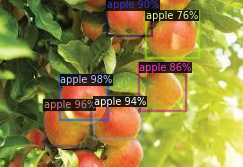

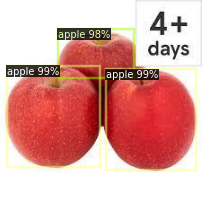

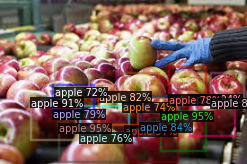

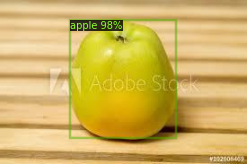

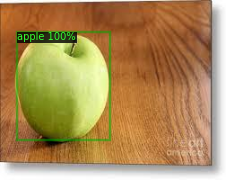

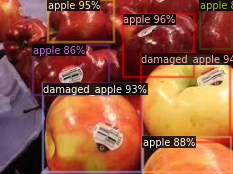

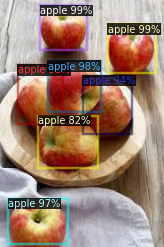

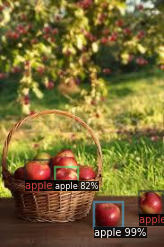

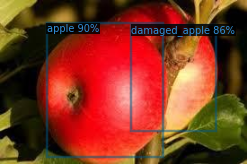

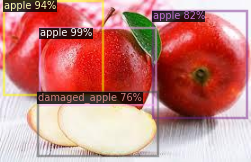

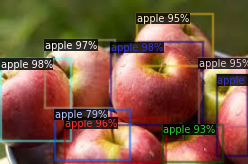

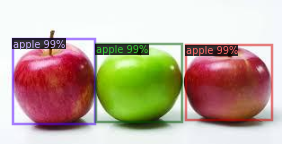

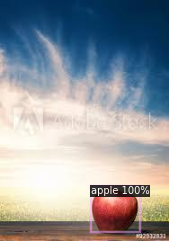

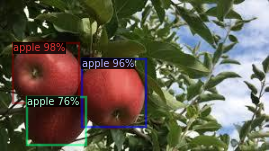

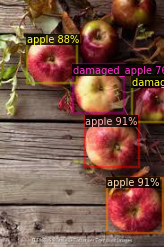

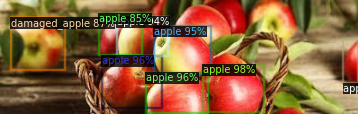

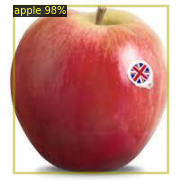

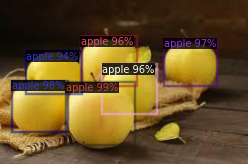

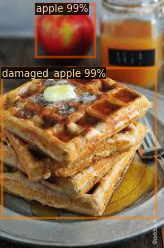

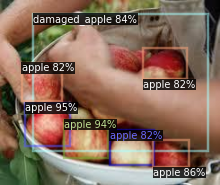

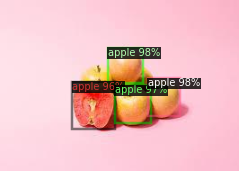

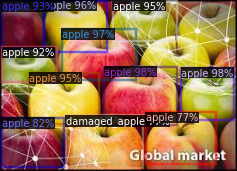

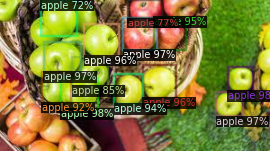

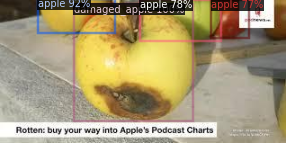

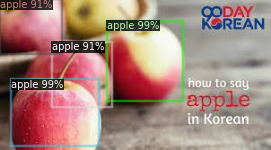

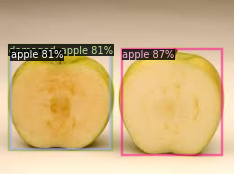

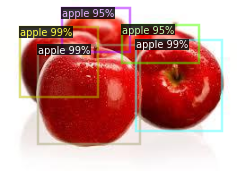

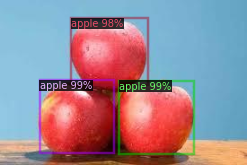

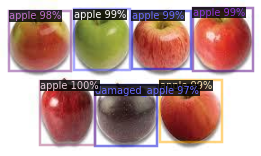

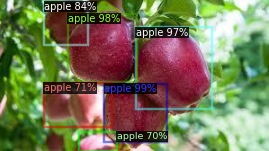

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.9
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
